### Neural Graph Revealers for modeling GGMs

- We design a synthetic experiment to study the capability of `Neural Graph Revealers` to recover conditional independence graph represented by Gaussian graphical models.  
- The input data X is sampled from a multivariate Gaussian distribution where we define the underlying precision matrix.   
- Run `NGRs` to recover the underlying graph between features that should ideally match the CI graph.

In [1]:
import os, sys
# reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
print(sys.prefix)
import warnings
warnings.filterwarnings('ignore')

import pickle

/anaconda/envs/ngm


### Setup the Gaussian graphical model
1. Initialize a graph type.
2. Get the precision matrix `theta` and corresponding samples `X` from a multivariate Gaussian distribution.
3. Get the partial correlations matrix `rho` and the graph `G`.

In [2]:
import numpy as np
import pandas as pd

# Local imports
from ngr.utils import ggm
from ngr.utils import data_processing as dp

# Xb - samples batch, trueTheta - corresponding true precision matrices
Xb, true_theta = ggm.get_data(
    num_nodes=10, 
    typeG='CHAIN', 
    sparsity=[0.2, 0.2], # Not used for chain graph
    num_samples=2000, 
    batch_size=1,
    eig_offset=0.1, # 0.5 #0.1, 
    w_min=0.5,
    w_max=1
)
X, true_theta = Xb[0], true_theta[0]
# set the column names for X
X = pd.DataFrame(X, columns=['n'+str(i) for i in range(X.shape[1])])
rho = ggm.get_partial_correlations(true_theta)
print(f'partial correlations: {rho.shape}, Samples {X.shape}')
G, image_G, graph_edge_list = ggm.graph_from_partial_correlations(rho, X.columns)

partial correlations: (10, 10), Samples (2000, 10)
Sparsity 1 using threshold 0.0


In [3]:
Gv = dp.get_interactive_graph(G, 'GGM Chain graph', node_PREFIX=None)
Gv.show('viz_ggm.html')

### Neural graph revealer

For faster runtimes, set USE_CUDA=True

In [25]:
import pandas as pd
import ngr.main as ngr
import ngr.utils.data_processing as dp

model_NGR = ngr.recover_graph(
    X, lambd=1e2,
    hidden_dim=200,
    epochs= 200000,
    lr= 0.00005, #0.0001, #0.0005,
    norm_type='min_max',
    k_fold=1,
    structure_penalty='hadamard',
    VERBOSE=True, 
    BATCH_SIZE=1000,#None#5000, #1000
) 
# NOTE: KEEP low learning rate and high number of epochs.


Means of selected features (n0   -0.052768
n1   -0.019441
n2    0.023159
n3   -0.010095
n4    0.005538
n5    0.021709
n6    0.014364
n7   -0.056324
n8   -0.078780
n9    0.007826
dtype: float64, 10)
Normalizing the data: min_max
: Processing the input table for basic compatibility check
: The input table has sample 2000 and features 10
: Total zero samples dropped 0
: Single value columns dropped: total 0, columns []
: The processed table has sample 2000 and features 10
: Total time to process the table 0.009 secs
Fold num 0
Initializing the NGR model

Fold 0: epoch:0/200000
Train: loss=3.8300092220306396, reg=0.25334906578063965, struct=0.0357666015625
Test: loss=3.828451633453369, reg=0.251791387796402, struct=0.0357666015625

Fold 0: epoch:20000/200000
Train: loss=2.69122052192688, reg=0.013352111913263798, struct=0.026778683066368103
Test: loss=2.6908962726593018, reg=0.01302801538258791, struct=0.026778683066368103

Fold 0: epoch:40000/200000
Train: loss=1.4616085290908813, reg=0.0

In [26]:
# Plot the graph
G_ngr = ngr.get_graph_NGR(model_NGR, sparsity=1)
# print(G_ngr.edges(data=True))
Gv_ngr = dp.get_interactive_graph(G_ngr, 'NGR graph', node_PREFIX=None)
Gv_ngr.show('viz_ngr.html')

Sparsity 1 using threshold 1.8383259885013103e-05


### Comparison 

In [27]:
# Comparing with true precision matrix
from ngr.utils.metrics import graph_compare_metrics
import networkx as nx

true_adj = np.array(nx.adjacency_matrix(G).todense())
ngr_adj = np.array(nx.adjacency_matrix(G_ngr).todense())
compare_results = graph_compare_metrics(
    (true_adj != 0).astype(int),# np.abs(true_adj), 
    np.abs(ngr_adj) # Compare with sparsity=1
)
print(f'NGR: {compare_results}')


NGR: {'FDR': 0.5263157894736842, 'TPR': 1.0, 'FPR': 0.2777777777777778, 'SHD': 10, 'nnzTrue': 9, 'nnzPred': 19, 'precision': 0.47368421052631576, 'recall': 1.0, 'Fbeta': 0.6428571428571429, 'aupr': 0.45882441145599034, 'auc': 0.845679012345679}


#### NGR Dependency functions

Features dropped from graph: set()
target=n1, source=n0
target=n1, source=n2


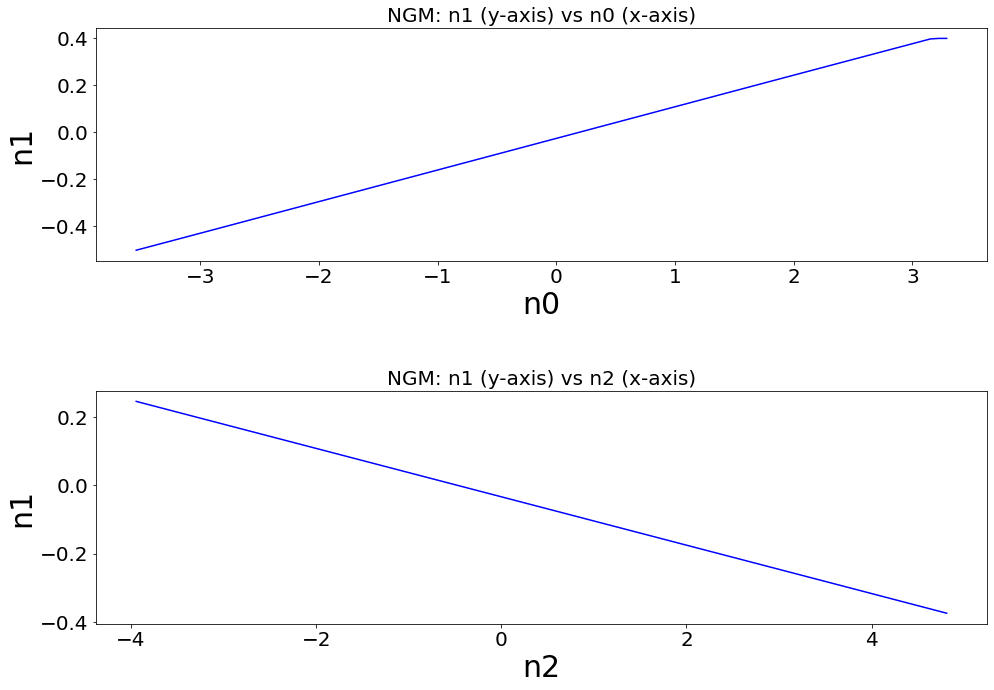

In [28]:
# Analyse the distribution details of the feature of interest
feature_of_interest = 'n1'
ngr.analyse_feature(feature_of_interest, model_NGR, G)#, dp.series2df(mean))